In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)
device = torch.device('mps')

In [8]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
vae.to(device)

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [9]:
vae

VAE(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc31): Linear(in_features=256, out_features=2, bias=True)
  (fc32): Linear(in_features=256, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=512, bias=True)
  (fc6): Linear(in_features=512, out_features=784, bias=True)
)

In [10]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [11]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [12]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [13]:
for epoch in range(1, 51):
    train(epoch)
    test()

/Users/ewriji/Library/Caches/pypoetry/virtualenvs/rnd-ve5eq-PE-py3.10/lib/python3.10/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 544.826953
Train Epoch: 1 [10000/60000 (17%)]	Loss: 193.056777
Train Epoch: 1 [20000/60000 (33%)]	Loss: 170.580195
Train Epoch: 1 [30000/60000 (50%)]	Loss: 165.089980
Train Epoch: 1 [40000/60000 (67%)]	Loss: 161.116270
Train Epoch: 1 [50000/60000 (83%)]	Loss: 167.760664
====> Epoch: 1 Average loss: 178.4310
====> Test set loss: 161.9940
Train Epoch: 2 [0/60000 (0%)]	Loss: 159.481182
Train Epoch: 2 [10000/60000 (17%)]	Loss: 161.431807
Train Epoch: 2 [20000/60000 (33%)]	Loss: 148.783437
Train Epoch: 2 [30000/60000 (50%)]	Loss: 146.994687
Train Epoch: 2 [40000/60000 (67%)]	Loss: 154.921396
Train Epoch: 2 [50000/60000 (83%)]	Loss: 148.287402
====> Epoch: 2 Average loss: 157.8435
====> Test set loss: 154.9270
Train Epoch: 3 [0/60000 (0%)]	Loss: 151.861738
Train Epoch: 3 [10000/60000 (17%)]	Loss: 159.269443
Train Epoch: 3 [20000/60000 (33%)]	Loss: 157.977500
Train Epoch: 3 [30000/60000 (50%)]	Loss: 154.920557
Train Epoch: 3 [40000/60000 (67%)]	Loss: 146.38

/Users/ewriji/Library/Caches/pypoetry/virtualenvs/rnd-ve5eq-PE-py3.10/lib/python3.10/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


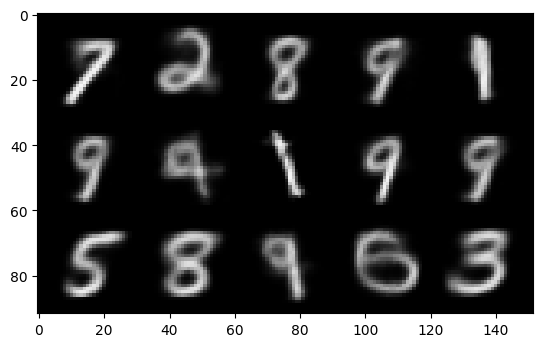

In [23]:
from torchvision.utils import make_grid
from matplotlib import pyplot as plt

with torch.no_grad():
    z = torch.randn(15, 2).to(device)
    generated = vae.decoder(z).reshape(-1,1,28,28).cpu()

    grid = make_grid(generated, nrow=5).permute(1,2,0)
    plt.imshow(grid)

In [1]:
import numpy as np

with torch.no_grad():
    rand_indices = np.random.choice(len(train_dataset), 200)
    x_samples, colors = [], []

    for idx in rand_indices:
        x, y = train_dataset[idx]

        x_samples.append(x[None])
        colors.append(y)

    x_samples = torch.cat(x_samples).to(device)
    projections = vae.encoder(x_samples.flatten(1))[0].cpu()

NameError: name 'torch' is not defined